[-98.17086885   1.44984922]


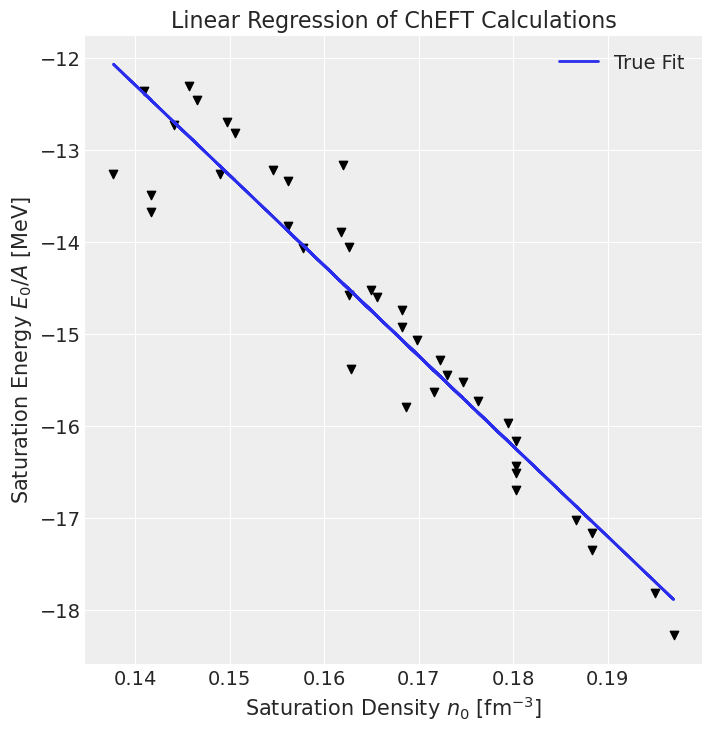

In [31]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

dtypes = {"hamiltonian": str, "hamiltonian_brief": str, "n0": np.float64, "En0": np.float64, "method": str, \
          "mbpt_order": np.float64,"set_id": str, "reference": str}
mytypes = {"n0": np.float64, "En0": np.float64}
dt = pd.read_csv("data/saturation_points.csv", comment = "#", usecols=[2,3])

x = dt["n0"]
y = dt["En0"]
                 

reg = np.polyfit(x, y, 1)  #TODO: not sure if 1/y is correct weights value
print(reg)

plt.figure(figsize=(8.6, 8.2))
plt.scatter(x, y, c='black', marker='v')
plt.title(label='Linear Regression of ChEFT Calculations')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0, label="True Fit")
plt.grid(True)
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
plt.ylabel('Saturation Energy $E_0/A$ [MeV]')
plt.legend()
plt.legend(loc='upper right')
plt.savefig("LinRegChEFT.pdf")
plt.show()

C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


C:\Users\sbezo\AppData\Local\Temp\ipykernel_22304\1947705241.py:10: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(1000, step, start=start, progressbar=False)
C:\Users\sbezo\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, $β_1$, $β_0$]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performa

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl
Could not locate executable gfortran
Could not locate executable f95
Could not locate executable g95
Could not locate executable efort
Could not locate executable efc
Could not locate executable flang
don't know how to compile Fortran code on platform 'nt'


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\sbezo\AppData\Local\Temp\ipykernel_22304\1947705241.py:12: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  fig = pm.traceplot(trace, lines={'beta_0': 4, 'beta_1': 2, 'sigma': 2})


{'$β_0$': 1.6674686780229293, '$β_1$': -99.05668097638161, '$\\sigma$_log__': -0.7438669275080111, '$\\sigma$': 0.47527251317590197}


C:\Users\sbezo\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:214: UserWarning: A valid var_name should be provided, found {'s', 'b'} expected from {'$β_0$', '$\\sigma$', '$β_1$'}
  warnings.warn(


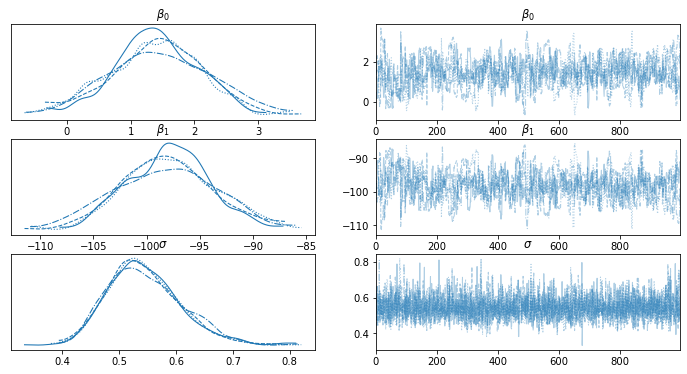

<Figure size 576x720 with 0 Axes>

In [2]:
 with pm.Model() as model:
        
    beta_0 = pm.Normal('$β_0$', mu=1.5, sd=1)
    beta_1 = pm.Normal('$β_1$', mu=-100, sd=50)
    sigma = pm.InverseGamma('$\sigma$', alpha=6, beta=5) #mean = 1 varience = .5^2
    y_est =  beta_0 + beta_1 * x
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(1000, step, start=start, progressbar=False)
    print(trace[0])
    fig = pm.traceplot(trace, lines={'beta_0': 4, 'beta_1': 2, 'sigma': 2})
    plt.figure(figsize=(8, 10))
    plt.show()

In [19]:
with model:
    dt = az.summary(trace, kind='stats')
    plt.savefig("SummaryChEFT.pdf")
    display(dt)
       
  


,mean,sd,hdi_3%,hdi_97%
$β_0$,1.417,0.717,0.107,2.749
$β_1$,-97.974,4.322,-106.040,-89.971
$\sigma$,0.545,0.064,0.432,0.666


<Figure size 720x480 with 0 Axes>

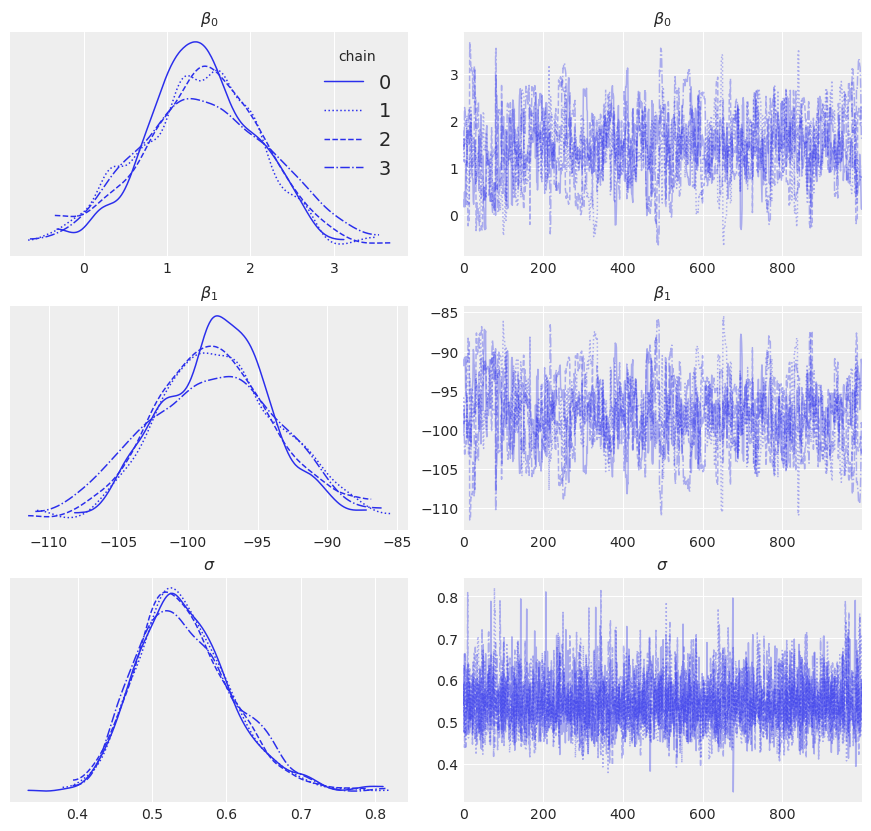

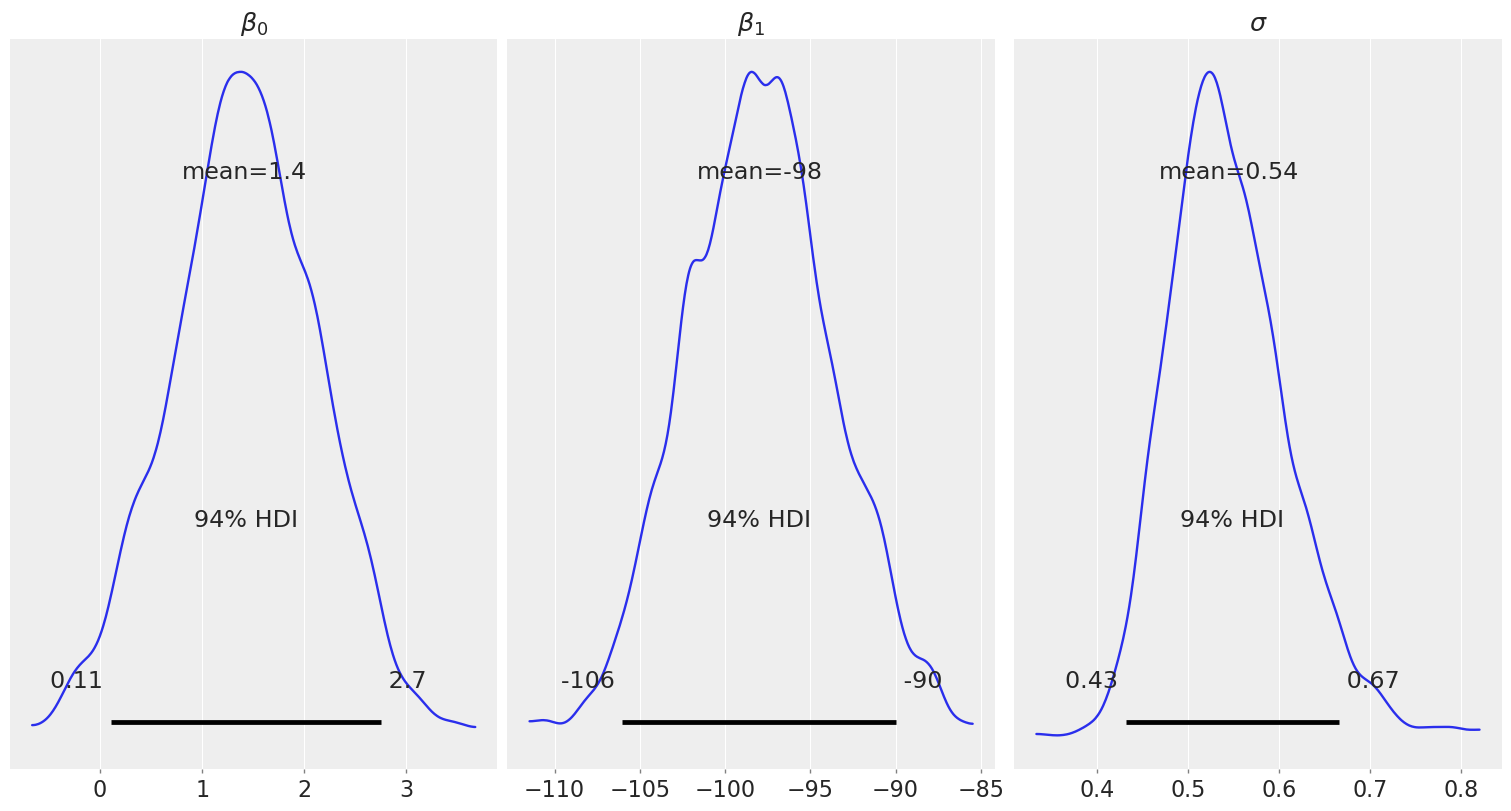

In [29]:
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42, progressbar=True)


with model: 
    trace_updated = az.from_pymc3(trace, posterior_predictive=ppc)
    
az.style.use("arviz-darkgrid")
with model:
  az.plot_trace(trace_updated, figsize=(8.6, 8.2), legend=True)
plt.savefig("SamplerChEFT.pdf")


az.style.use("arviz-darkgrid")
with model:
  az.plot_posterior(trace_updated,textsize=16, figsize=(15, 8))

plt.savefig("PosteriorsChEFT.pdf")

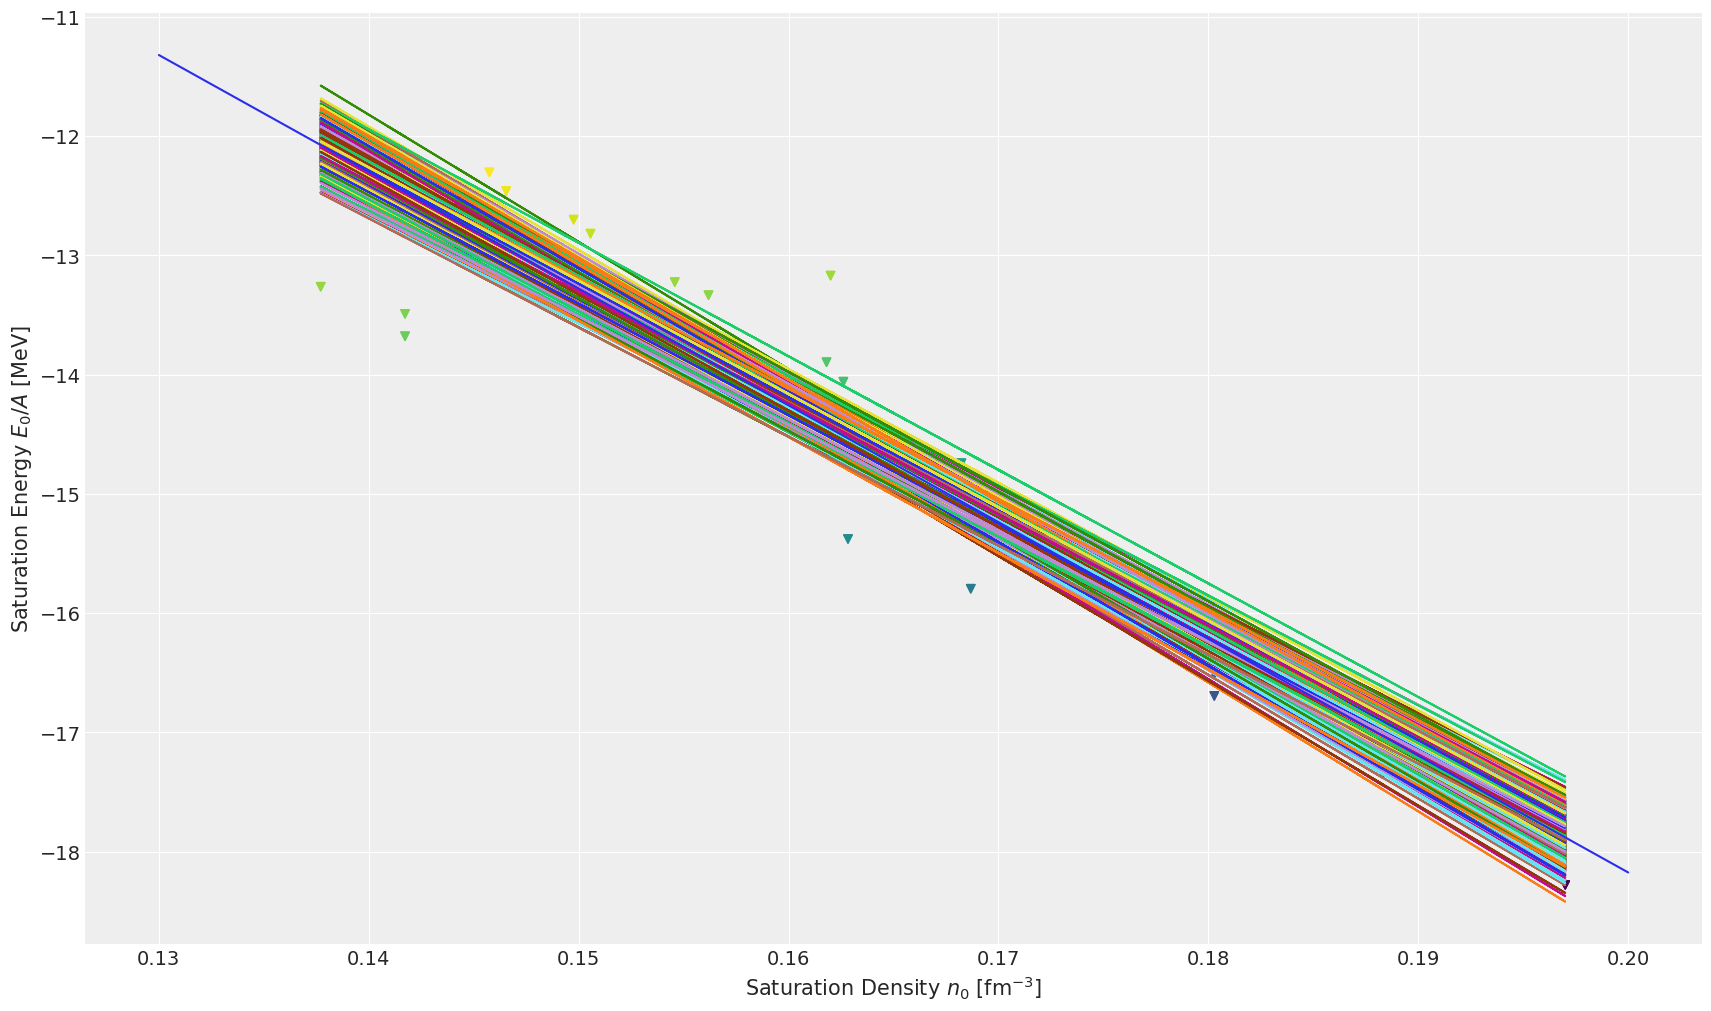

In [5]:
plt.figure(figsize=(17,10))
plt.scatter(x, y, c=y, marker='v')
plt.grid(True)
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
plt.ylabel('Saturation Energy $E_0/A$ [MeV]')


for i in range(len(trace)): 
    plt.plot(x, trace['$β_0$'][i] + trace['$β_1$'][i] * x) #TODO: Add uncertainity band, add credibility level, make color code meaningful
    

density = np.linspace(.13,.2,100)
sumArray = [0] * 100
for i in range(100):
   for line in range(len(trace)):
      sumArray[i] = (trace['$β_0$'][line] + trace['$β_1$'][line] * density[i]) + sumArray[i]
   sumArray[i] = sumArray[i] / len(trace) 

y_average = sumArray



plt.plot(density, y_average)
plt.scatter(x, y, c=y, marker='v')

plt.show()

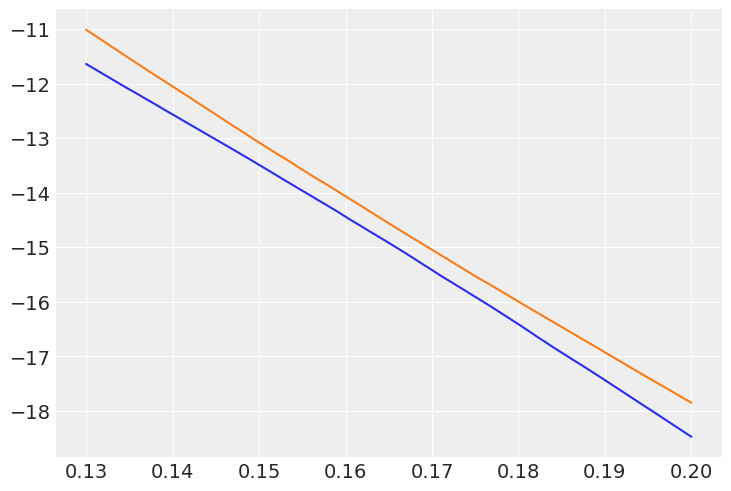

In [6]:
y_max = [0] * 100
y_min = [0] * 100
temp_array = [0] * len(trace)
for i in range(100):
    for line in range(len(trace)):
          temp_array[line] = (trace['$β_0$'][line] + trace['$β_1$'][line] * density[i])
    temp_array = np.sort(temp_array)
    y_max[i] = temp_array[974] 
    y_min[i] = temp_array[24]

plt.plot(density, y_min)
plt.plot(density, y_max)

  

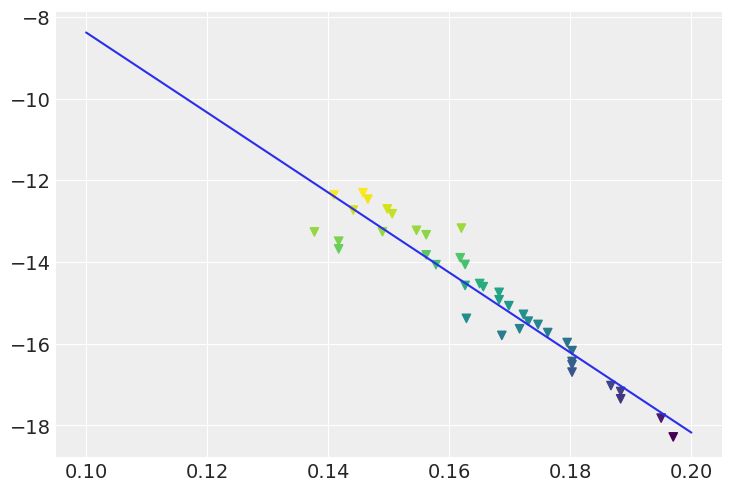

In [7]:
density = np.linspace(.1,.2,100)
sumArray = [0] * 100
for i in range(100):
   for line in range(len(trace)):
      sumArray[i] = (trace['$β_0$'][line] + trace['$β_1$'][line] * density[i]) + sumArray[i]
   sumArray[i] = sumArray[i] / len(trace)

plt.plot(density, sumArray)
plt.scatter(x, y, c=y, marker='v')

In [8]:
beta_0_mean = dt['mean']['$β_0$']     
beta_0_std = dt['sd']['$β_0$']
beta_1_mean = dt['mean']['$β_1$']
beta_1_std = dt['sd']['$β_1$']



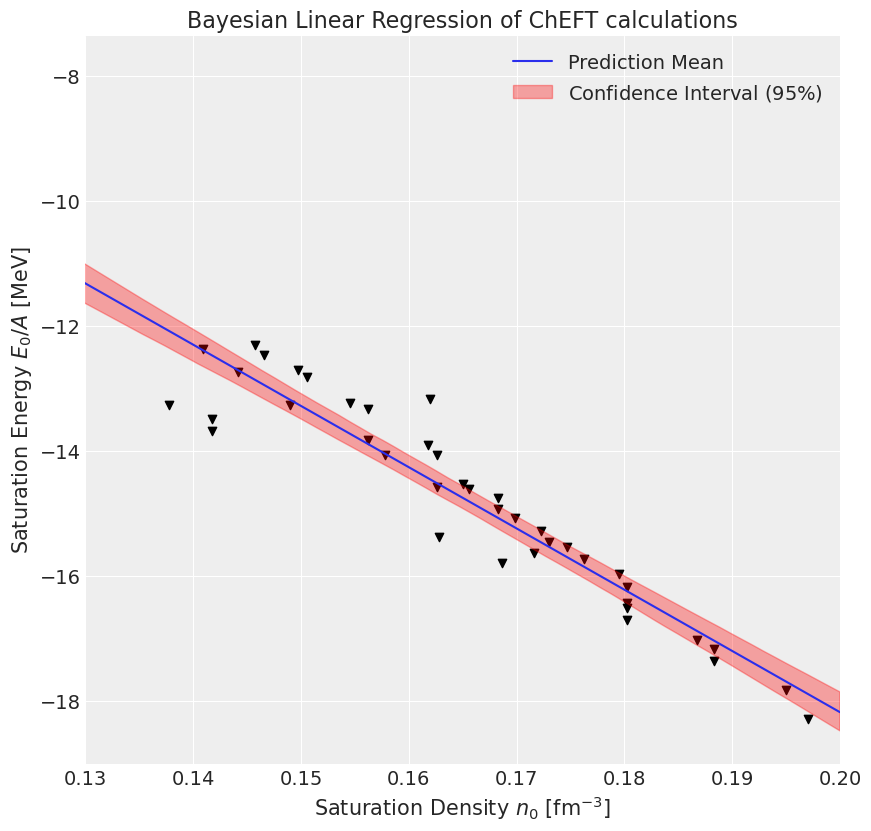

In [21]:
density = np.linspace(.1,.2,100)
sumArray = [0] * 100
for i in range(100):
    for line in range(len(trace)):
        sumArray[i] = (trace['$β_0$'][line] + trace['$β_1$'][line] * density[i]) + sumArray[i]
    sumArray[i] = sumArray[i] / len(trace)

y_average = sumArray
y_max = [0] * 100
y_min = [0] * 100
temp_array = [0] * len(trace)

for i in range(100):
    for line in range(len(trace)):
          temp_array[line] = (trace['$β_0$'][line] + trace['$β_1$'][line] * density[i])
    temp_array = np.sort(temp_array)
    y_max[i] = temp_array[974] 
    y_min[i] = temp_array[25]
    

plt.figure(figsize=(8.6, 8.2))
plt.xlim([.13,.2])
plt.scatter(x, y, c='black', marker='v')
plt.grid(True)
plt.title(label = 'Bayesian Linear Regression of ChEFT calculations')
plt.xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
plt.ylabel('Saturation Energy $E_0/A$ [MeV]')
plt.plot(density, y_average, label='Prediction Mean')
plt.legend()
plt.fill_between(density, y_min , y_max , color='r', alpha=.33, label= 'Confidence Interval ($95\%$)')
plt.legend(loc='upper right')
plt.savefig("BayesianLinRegChEFT.pdf")